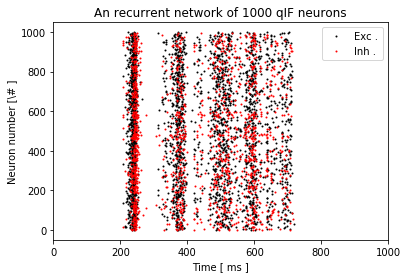

In [4]:
from pylab import *
from scipy.sparse import csr_matrix

# initialize parameters
tmax = 1000
dt = 0.5

# 1 . 1 ) Neuron / Network pars
n = 1000 # number of neurons
pinh = 0.2 # prob of inh neuron
inh = (uniform (size=n)<pinh) # whether inh .
exc = logical_not(inh)
a = inh.choose(0.02, 0.1)# exc =0.02 , inh=0.1
b = 0.2
c = -65
d = inh.choose(8,2) # exc =8, inh=2
tau_s = 10

# NEW recurrent parameter
w = 0.005 # averagere current weight
pconn = 0.1 # recurrent connection prob
scaleEI = 2 # scale I−>E
g_sc= 0.002 # scale of gamma
E = inh.choose(0,-85)
# NEW: make weight matrix
W = zeros((n,n))
C = uniform(size=(n,n))
idx=nonzero(C<pconn) # sparse connectivity
W[idx] = gamma(w/g_sc,scale=g_sc,size=idx[0].size)
W[ix_(exc,inh)] *= scaleEI #submat indexing
W = csr_matrix(W) # make row sparse

#  Input pars
tr=array([200,700])/dt # stm time
rate_in = 2 # input rate
n_in = 100 # number of inputs
w_in = 0.07 # input weights
pconn_in = 0.1 # input conn prob
C = uniform(size=(n, n_in))< pconn_in
W_in = C.choose(0, w_in) # matrix

#  reserve memory
T = int(ceil(tmax/dt))
v = zeros((T, n)) # now matrix
u = zeros((T, n)) # now matrix
v[0] = -70 # resting potential
u[0] = -14 # steady state
s_in = zeros(n_in) # synaptic variable
E_in = zeros(n_in) #rev potential
prate = dt*rate_in*1e-3 # abbrev
s = zeros(n) # rec synapses

#  for loop over time
for t in arange(T-1):
    # get input
    if t>tr[0] and t<tr[1]:
     # NEW: get input Poisson spikes
        p = uniform(size=n_in)<prate;
    else:
        p = 0; # no input
        
    s_in = (1-dt/tau_s)*s_in + p
    I = dot(W_in , s_in*E_in)
    I -= dot(W_in , s_in)*v[t]
    
    # NEW: handle all neurons
    fired = v[t]>=35
    # NEW: recurrent input
    s =(1-dt/tau_s)*s + fired
    Isyn = W.dot(s*E) - W.dot(s)*v[t]
    I += Isyn # add to input vector
    #  update ODE, simply update all
    dv = (0.04*v[t]+5)*v[t]+140-u[t]
    v[t+1] = v[t]+(dv+I)*dt
    du = a*(b*v[t]-u[t])
    u[t+1] = u[t] + dt*du
  
     #  spike !
    v[t][fired] = 35
    v[t+1][fired] = c
    u[t+1][fired] = u[t][fired]+d[fired]
    
# 4 ) plotting
# NEW: get spikes and plot
tspk, nspk = nonzero(v==35)
idx_i = in1d(nspk ,nonzero(inh)[0]) # find inh
idx_e = logical_not(idx_i) # all others are exc

figure()
plot (tspk[idx_e]* dt ,nspk[idx_e] ,'k .',
      label='Exc .' , markersize =2)
plot (tspk[idx_i]*dt,nspk[idx_i], 'r .' ,
      label='Inh . ' , markersize =2)
xlabel ('Time [ ms ]')
ylabel ('Neuron number [\# ]')
xlim ((0,tmax))
title ('An recurrent network of %d qIF neurons'  % n)
legend (loc='upper right')
show()